In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
print(f"TensorFlow ver: {tf.__version__}")
print(f"GPU able: {tf.config.list_physical_devices('GPU')}")
tf.config.experimental.enable_op_determinism()
tf.random.set_seed(42)

TensorFlow ver: 2.19.0
GPU able: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import keras
keras.utils.set_random_seed(42)

In [4]:
import os, json, math, random
import numpy as np
import pandas as pd

In [5]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [6]:
data_dir = '/content/drive/MyDrive/UMLTA3'

X_ai = np.load(os.path.join(data_dir, "train_ai.npy"))
X_human = np.load(os.path.join(data_dir, "train_human.npy"))

df_val = pd.read_json(os.path.join(data_dir, "validation.jsonl"), lines=True)
df_test = pd.read_json(os.path.join(data_dir, "test_features.jsonl"), lines=True)

In [7]:
X_val_list, y_val_list, val_id_list = [], [], []
for row in df_val.itertuples():
    arr = np.array(row.features, dtype=np.float32)   # (N_i,100,768)
    for sub in arr:  # sub is slice for each id: (100,768)
        X_val_list.append(sub)
        y_val_list.append(row.label)
        val_id_list.append(row.id)

X_val = np.stack(X_val_list)
y_val = np.array(y_val_list)
val_ids = np.array(val_id_list)

print(X_val.shape, y_val.shape, val_ids.shape, len(np.unique(val_ids)))

(220, 100, 768) (220,) (220,) 20


In [8]:
X_test_list, test_id_list = [], []
for row in df_test.itertuples():
    arr = np.array(row.features, dtype=np.float32)
    for sub in arr:
        X_test_list.append(sub)
        test_id_list.append(row.id)

X_test = np.stack(X_test_list)
test_ids = np.array(test_id_list)

print(X_test.shape, test_ids.shape, len(np.unique(test_ids)))

(1686, 100, 768) (1686,) 180


In [9]:
from sklearn.utils import shuffle

y_ai = np.ones(len(X_ai),  dtype=np.int32)
y_human = np.zeros(len(X_human), dtype=np.int32)

X_train = np.concatenate([X_ai, X_human], axis=0)
y_train = np.concatenate([y_ai, y_human], axis=0)

X_train, y_train = shuffle(X_train, y_train, random_state=SEED)

print(X_train.shape, y_train.shape)

(16322, 100, 768) (16322,)


Prepare for evaluate function

In [10]:
import matplotlib.pyplot as plt

def plot_history(history):

    hist = history.history
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # --- Loss ---
    axes[0].plot(hist["loss"], label="train")
    if "val_loss" in hist:
        axes[0].plot(hist["val_loss"], label="val")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # --- Accuracy ---
    if "accuracy" in hist:
        axes[1].plot(hist["accuracy"], label="train")
    if "val_accuracy" in hist:
        axes[1].plot(hist["val_accuracy"], label="val")
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    # --- ROC AUC ---
    if "roc_auc" in hist:
        axes[2].plot(hist["roc_auc"], label="train")
    if "val_roc_auc" in hist:
        axes[2].plot(hist["val_roc_auc"], label="val")
    axes[2].set_title("ROC AUC")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("AUC")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

In [11]:
from sklearn.metrics import roc_auc_score, classification_report

def evaluate_model(model, X, y, ids=None, agg="mean", threshold=0.5, digits=3):

    # ---- Sequence Level ----
    probs = model.predict(X).ravel()
    auc_sample = roc_auc_score(y, probs)
    preds = (probs > threshold).astype(int)

    print("Sample-level AUROC:", round(auc_sample, 4))
    print("Classification Report (sample-level):")
    print(classification_report(y, preds, digits=digits))

    auc_doc = None
    if ids is not None and agg is not None:
        doc_probs = {}
        doc_labels = {}
        for p, yy, i in zip(probs, y, ids):
            doc_probs.setdefault(i, []).append(p)
            doc_labels[i] = yy

        # merge
        if agg == "mean":
            doc_probs = {i: np.mean(v) for i, v in doc_probs.items()}
        elif agg == "max":
            doc_probs = {i: np.max(v) for i, v in doc_probs.items()}
        elif agg == "vote":
            doc_probs = {i: (np.mean(v) > 0.5).astype(float) for i, v in doc_probs.items()}
        else:
            raise ValueError("agg must be 'mean' | 'max' | 'vote'")

        doc_probs = np.array(list(doc_probs.values()))
        doc_labels = np.array(list(doc_labels.values()))
        auc_doc = roc_auc_score(doc_labels, doc_probs)

        print(f"Doc-level AUROC ({agg}):", round(auc_doc, 4))

Compare Candidate Model - Baseline Performance on BiGRU

In [12]:
inp = tf.keras.Input(shape=(100,768))
x = tf.keras.layers.Masking(mask_value=0.0)(inp)
x = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.0)
)(x)

x = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=128)(x, x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
out = tf.keras.layers.Dense(1, activation="sigmoid", dtype="float32")(x)

bigru_light = tf.keras.Model(inp, out)
bigru_light.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(curve="ROC", name="roc_auc")]
)

bigru_light.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 100, 768)  │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 100, 768)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 100)       │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 100, 128)  │    320,256 │ masking[0][0],    │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 128)  │    263,808 │ bidirectional[0]… │
│ (MultiHeadAttentio… │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 592,385 (2.26 MB)

 Trainable params: 592,385 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_roc_auc", patience=5,
    restore_best_weights=True, verbose=1
)

In [14]:
history_grubaseline = bigru_light.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_val, y_val),
                    batch_size=32,
                    callbacks=[es],
                    verbose=1)

Epoch 1/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.7691 - loss: 0.4821 - roc_auc: 0.8446 - val_accuracy: 0.7000 - val_loss: 0.8687 - val_roc_auc: 0.7886
Epoch 2/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8601 - loss: 0.3394 - roc_auc: 0.9307 - val_accuracy: 0.7273 - val_loss: 0.8261 - val_roc_auc: 0.8084
Epoch 3/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8697 - loss: 0.3137 - roc_auc: 0.9400 - val_accuracy: 0.7182 - val_loss: 0.7228 - val_roc_auc: 0.8085
Epoch 4/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8704 - loss: 0.3071 - roc_auc: 0.9428 - val_accuracy: 0.7182 - val_loss: 0.9264 - val_roc_auc: 0.8032
Epoch 5/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8717 - loss: 0.3048 - roc_auc: 0.9438 - val_accuracy: 0.7000 - val_loss: 0.7005 - val_roc_auc: 0.8017
Epoch 6/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8832 - loss: 0.2793 - roc_auc: 0.9520 - val_accuracy: 0.7227 - val_loss: 0.7239 - val_r

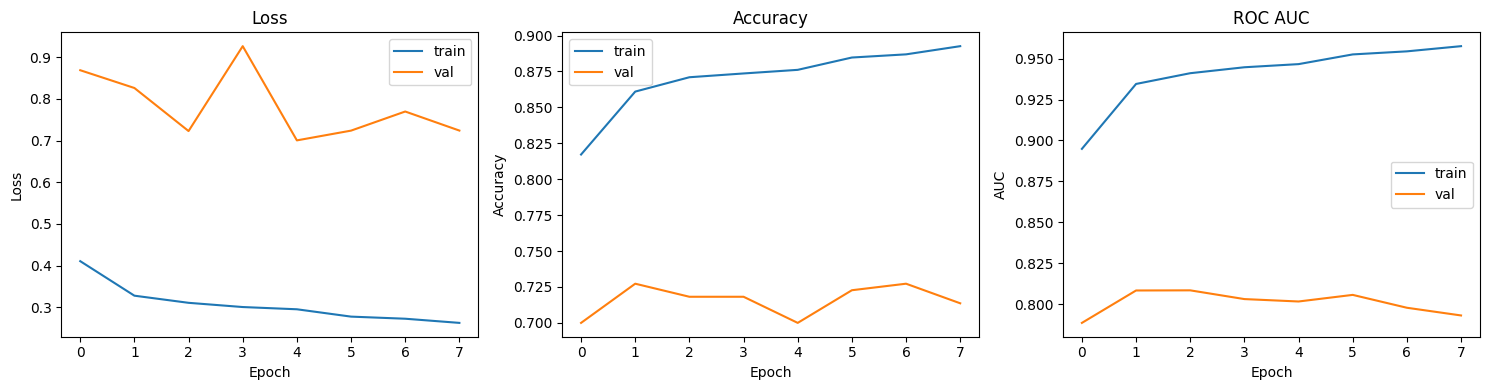

In [15]:
plot_history(history_grubaseline)

In [16]:
evaluate_model(model=bigru_light, X=X_val, y=y_val, ids=val_ids, agg="mean")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Sample-level AUROC: 0.8102
Classification Report (sample-level):
              precision    recall  f1-score   support

           0      0.699     0.879     0.779       124
           1      0.766     0.510     0.613        96

    accuracy                          0.718       220
   macro avg      0.732     0.695     0.696       220
weighted avg      0.728     0.718     0.706       220

Doc-level AUROC (mean): 1.0


Compare Candidate Model - Baseline Performance on TextCNN

In [17]:
inp = tf.keras.Input(shape=(100,768))

c3 = tf.keras.layers.Conv1D(64, 3, padding="same", activation="relu")(inp)
c5 = tf.keras.layers.Conv1D(64, 5, padding="same", activation="relu")(inp)
c7 = tf.keras.layers.Conv1D(64, 7, padding="same", activation="relu")(inp)

p = tf.keras.layers.concatenate([
    tf.keras.layers.GlobalMaxPool1D()(c3),
    tf.keras.layers.GlobalMaxPool1D()(c5),
    tf.keras.layers.GlobalMaxPool1D()(c7),
])

p = tf.keras.layers.Dense(64, activation="relu")(p)
p = tf.keras.layers.Dropout(0.2)(p)
out = tf.keras.layers.Dense(1, activation="sigmoid", dtype="float32")(p)

textcnn_light = tf.keras.Model(inp, out)
textcnn_light.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(curve="ROC", name="roc_auc")]
)

textcnn_light.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 100, 64)   │    147,520 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 100, 64)   │    245,824 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 100, 64)   │    344,128 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     12,352 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 749,889 (2.86 MB)

 Trainable params: 749,889 (2.86 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history_cnnbaseline = textcnn_light.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_val, y_val),
                    batch_size=32,
                    callbacks=[es],
                    verbose=1)

Epoch 1/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7750 - loss: 0.4766 - roc_auc: 0.8510 - val_accuracy: 0.7000 - val_loss: 0.8582 - val_roc_auc: 0.7825
Epoch 2/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8688 - loss: 0.3133 - roc_auc: 0.9404 - val_accuracy: 0.7045 - val_loss: 0.7645 - val_roc_auc: 0.7930
Epoch 3/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8880 - loss: 0.2752 - roc_auc: 0.9537 - val_accuracy: 0.7273 - val_loss: 0.7155 - val_roc_auc: 0.8048
Epoch 4/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8944 - loss: 0.2545 - roc_auc: 0.9603 - val_accuracy: 0.7273 - val_loss: 0.7383 - val_roc_auc: 0.8046
Epoch 5/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9002 - loss: 0.2425 - roc_auc: 0.9639 - val_accuracy: 0.7182 - val_loss: 0.7760 - val_roc_auc: 0.8033
Epoch 6/20
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9074 - loss: 0.2291 - roc_auc: 0.9678 - val_accuracy: 0.7409 - val_loss: 0.7870 - val_roc_auc

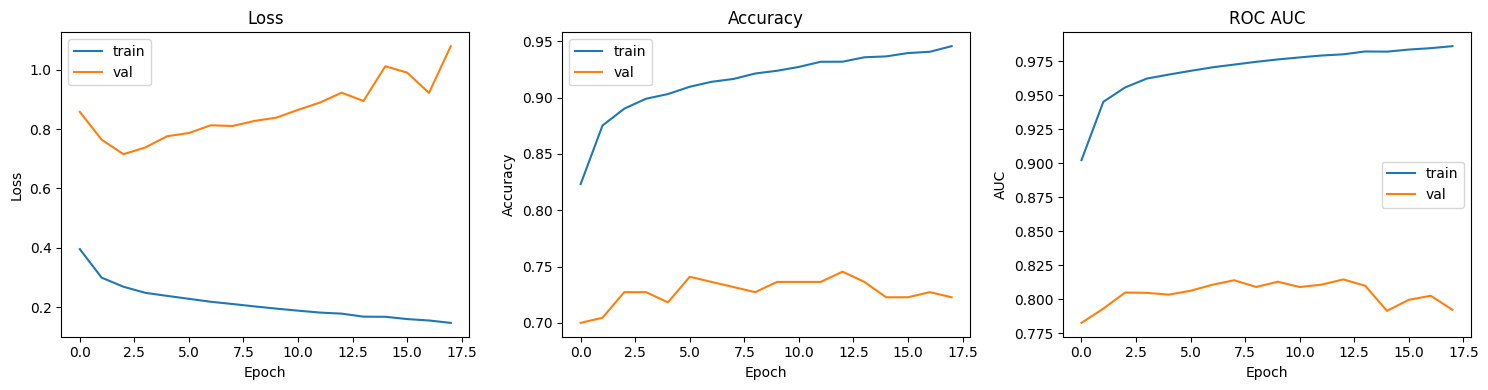

In [19]:
plot_history(history_cnnbaseline)

In [20]:
evaluate_model(model=textcnn_light, X=X_val, y=y_val, ids=val_ids, agg="mean")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Sample-level AUROC: 0.8154
Classification Report (sample-level):
              precision    recall  f1-score   support

           0      0.705     0.944     0.807       124
           1      0.870     0.490     0.627        96

    accuracy                          0.745       220
   macro avg      0.788     0.717     0.717       220
weighted avg      0.777     0.745     0.728       220

Doc-level AUROC (mean): 1.0


Based on the result we will select TextCNN to do the task and tune the model

In [21]:
def _apply_act(x, spec):
    # 字符串: "relu" / "tanh" / "sigmoid" / ...
    if isinstance(spec, str):
        return keras.layers.Activation(spec)(x)
    # 层类: keras.layers.LeakyReLU / keras.layers.ELU / ...
    if isinstance(spec, type) and issubclass(spec, keras.layers.Layer):
        return spec()(x)
    # 工厂函数: lambda: keras.layers.LeakyReLU(negative_slope=0.01)
    if callable(spec):
        return spec()(x)
    raise ValueError("Unsupported activation spec (use str, Layer class, or factory callable).")

In [22]:
def model_textcnn_factory(
    conv_filters=64,
    conv_activation="relu",
    dense_units=64,
    dense_activation="relu",
    dropout=0.2,
    optimizer_cls=keras.optimizers.Adam,
    learning_rate=1e-3,
    input_shape=(100, 768),
    kernel_sizes=(3, 5, 7),
):
    inp = keras.layers.Input(shape=input_shape)

    branches = []
    for k in kernel_sizes:
        x = keras.layers.Conv1D(conv_filters, k, padding="same", activation=None)(inp)
        x = _apply_act(x, conv_activation)          # <- 统一在这里加激活
        x = keras.layers.GlobalMaxPool1D()(x)
        branches.append(x)

    p = keras.layers.Concatenate()(branches) if len(branches) > 1 else branches[0]

    if dense_units and dense_units > 0:
        z = keras.layers.Dense(dense_units, activation=None)(p)
        z = _apply_act(z, dense_activation)         # <- Dense 的激活也复用同样逻辑
        z = keras.layers.Dropout(dropout)(z)
    else:
        z = p

    out = keras.layers.Dense(1, activation="sigmoid", dtype="float32")(z)
    model = keras.Model(inp, out)
    model.compile(
        optimizer=optimizer_cls(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy", keras.metrics.AUC(curve="ROC", name="roc_auc")]
    )
    return model

In [23]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_roc_auc", patience=5,
    restore_best_weights=True, verbose=1
)

tune filter units and filter activation function

In [24]:
FIXED = dict(
    dense_units=64,
    dense_activation="relu",
    dropout=0.2,
    optimizer_cls=keras.optimizers.Adam,
    learning_rate=1e-3,
    input_shape=(100, 768),
    kernel_sizes=(3, 5, 7),
)

In [25]:
conv_filters_grid = [64, 96, 128, 256]
conv_act_grid = ["relu", keras.layers.LeakyReLU]

In [26]:
num_model_cnn = 0
results_cnn1 = []

CNN Model- 1. conv_filters: 64, conv_activation: relu
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.


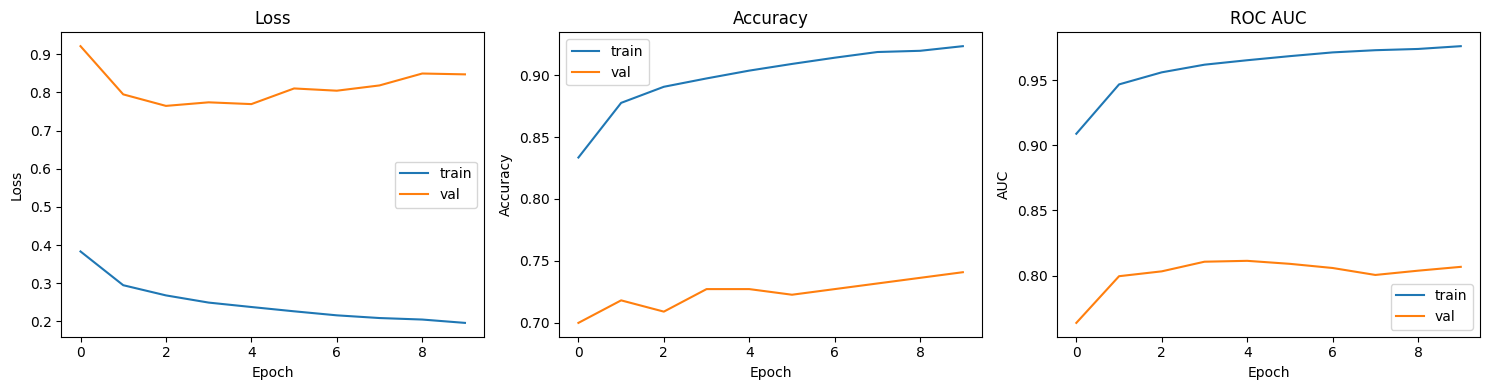

Accuracy of model-1: 0.7409 | ROC_AUC: 0.8114

CNN Model- 2. conv_filters: 64, conv_activation: type
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 10.


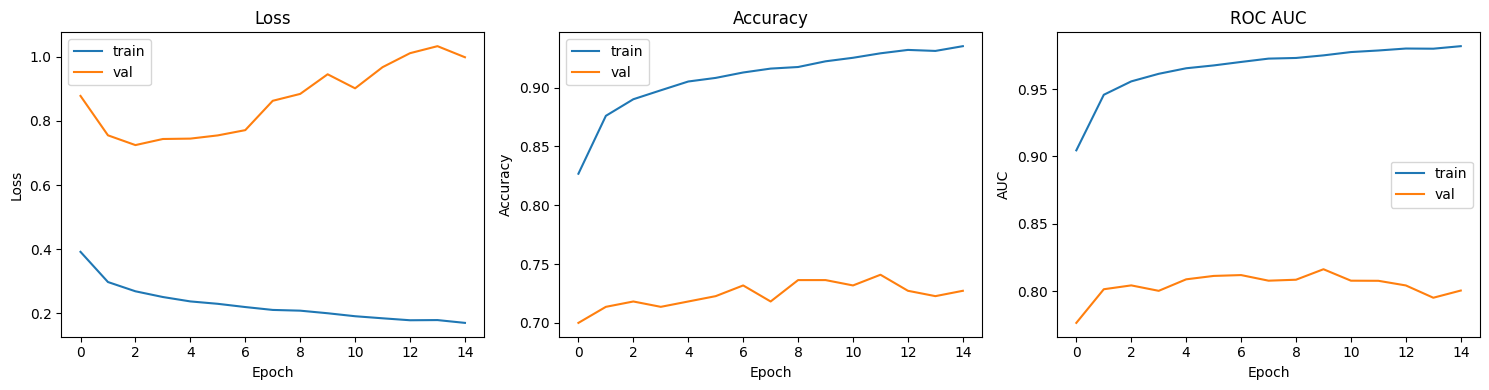

Accuracy of model-2: 0.7409 | ROC_AUC: 0.8164

CNN Model- 3. conv_filters: 96, conv_activation: relu
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 11.


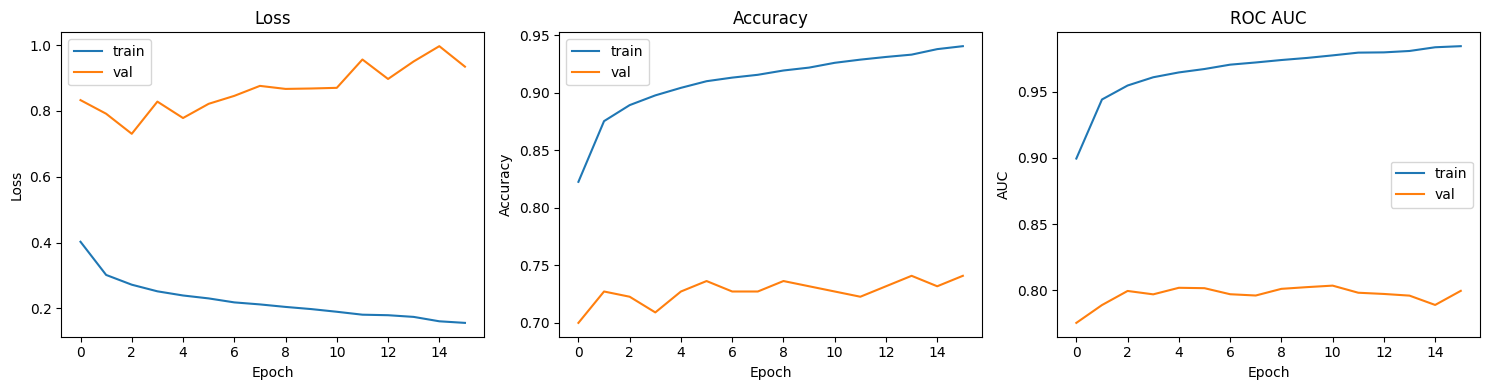

Accuracy of model-3: 0.7409 | ROC_AUC: 0.8034

CNN Model- 4. conv_filters: 96, conv_activation: type
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 11.


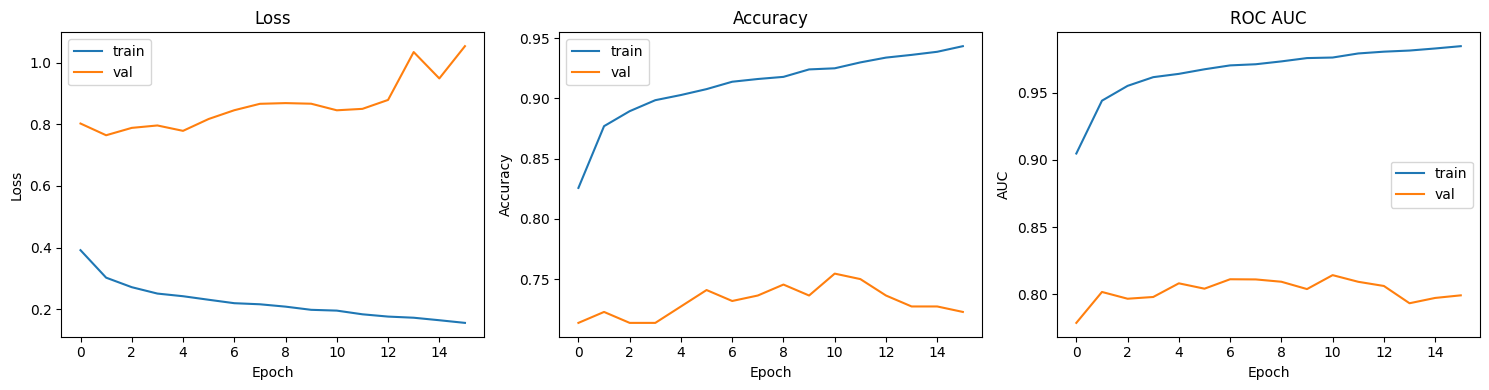

Accuracy of model-4: 0.7545 | ROC_AUC: 0.8142

CNN Model- 5. conv_filters: 128, conv_activation: relu
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.


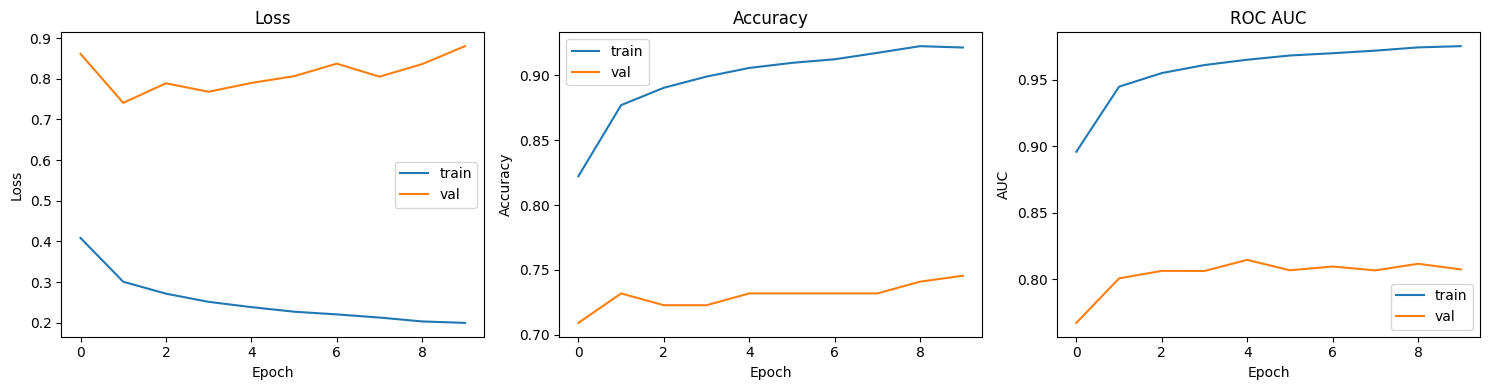

Accuracy of model-5: 0.7455 | ROC_AUC: 0.8147

CNN Model- 6. conv_filters: 128, conv_activation: type
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.


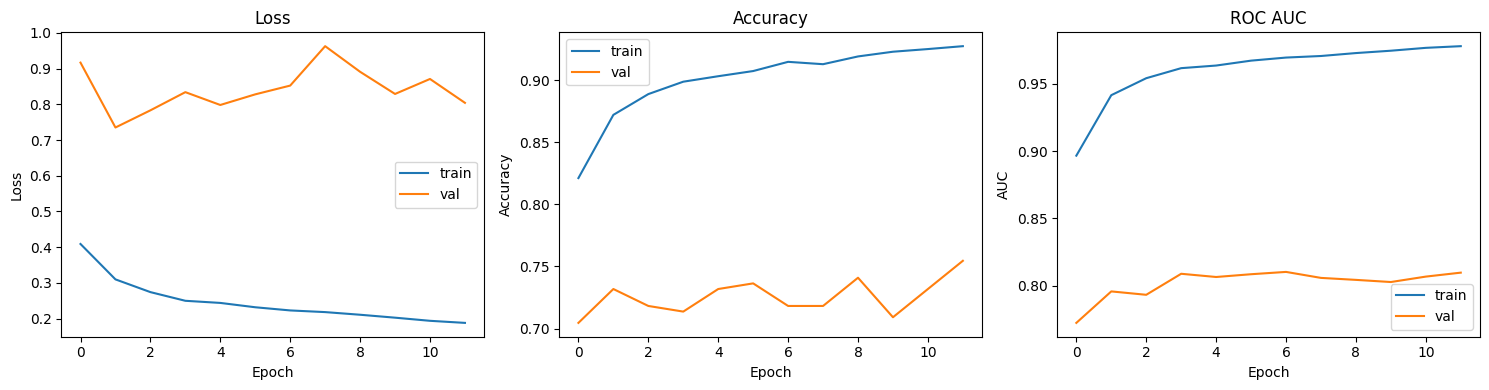

Accuracy of model-6: 0.7545 | ROC_AUC: 0.8101

CNN Model- 7. conv_filters: 256, conv_activation: relu
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.


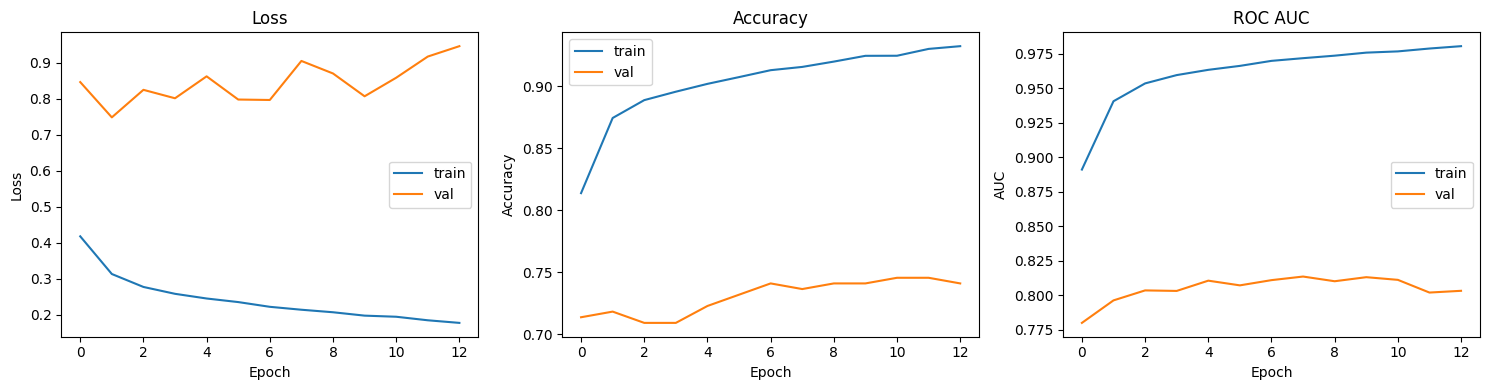

Accuracy of model-7: 0.7455 | ROC_AUC: 0.8136

CNN Model- 8. conv_filters: 256, conv_activation: type
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.


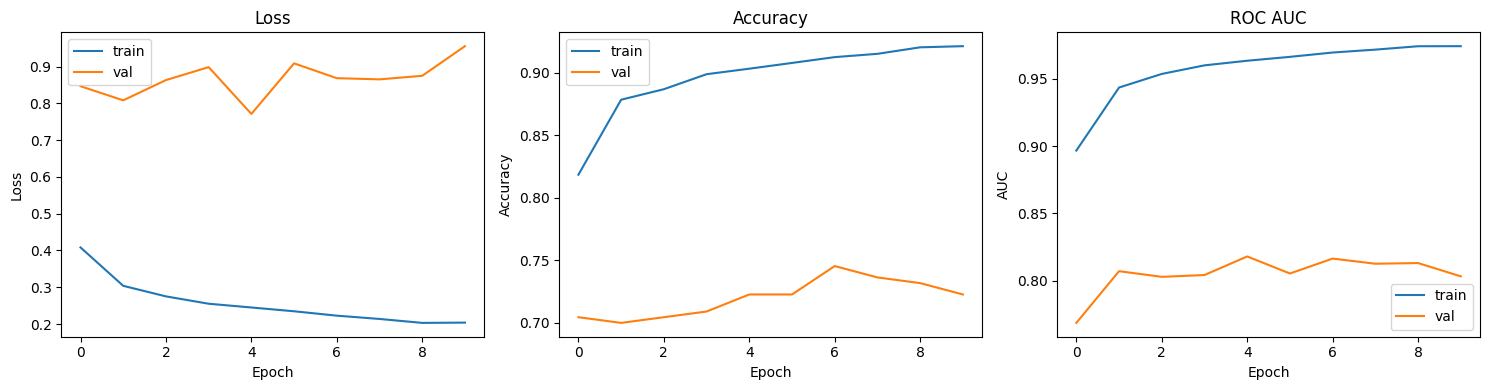

Accuracy of model-8: 0.7455 | ROC_AUC: 0.8180



In [27]:
for conv_filters in conv_filters_grid:
    for conv_act in conv_act_grid:
        num_model_cnn += 1
        actfn_name = conv_act if isinstance(conv_act, str) else conv_act.__class__.__name__
        print(f"CNN Model- {num_model_cnn}. conv_filters: {conv_filters}, conv_activation: {actfn_name}")

        model = model_textcnn_factory(
            conv_filters=conv_filters,
            conv_activation=conv_act,
            **FIXED
        )

        history = model.fit(
            X_train, y_train,
            epochs=40, batch_size=32,
            callbacks=[es],              # 你已有的 EarlyStopping
            validation_data=(X_val, y_val),
            verbose=0
        )

        # 记录最优指标
        val_acc = float(np.max(history.history.get("val_accuracy", [0.0])))
        val_auc = float(np.max(history.history.get("val_roc_auc", [0.0])))
        results_cnn1.append([round(val_acc, 4), round(val_auc, 4),
                             num_model_cnn, actfn_name, conv_filters])

        # 画曲线
        try:
            plot_history(history)  # 如果你的函数只接 history
        except TypeError:
            model_name = f'CNN Model {num_model_cnn}'
            plot_history(history, model_name)

        print(f"Accuracy of model-{num_model_cnn}: {val_acc:.4f} | ROC_AUC: {val_auc:.4f}\n")


In [28]:
results_cnn1.sort(key=lambda x: (x[1], x[0]), reverse=True)
print("Sorted (val_acc, val_auc, id, actfn, conv_filters):")
for row in results_cnn1:
    print(row)

Sorted (val_acc, val_auc, id, actfn, conv_filters):
[0.7455, 0.818, 8, 'type', 256]
[0.7409, 0.8164, 2, 'type', 64]
[0.7455, 0.8147, 5, 'relu', 128]
[0.7545, 0.8142, 4, 'type', 96]
[0.7455, 0.8136, 7, 'relu', 256]
[0.7409, 0.8114, 1, 'relu', 64]
[0.7545, 0.8101, 6, 'type', 128]
[0.7409, 0.8034, 3, 'relu', 96]


In [104]:
best_row = results_cnn1[0]   # [val_acc, val_auc, id, actfn, conv_filters]

best_acc_cnn = best_row[0]
best_auc_cnn = best_row[1]
best_actfn_name = best_row[3]
best_conv_filters = best_row[4]

if best_actfn_name.lower() == "relu":
    actfn_cnn = "relu"
else:
    actfn_cnn = keras.layers.LeakyReLU  # 注意用 negative_slope 替代 alpha

hiddensizes_cnn = best_conv_filters

print(f"✅ Best CNN Config | val_acc={best_acc_cnn}, val_auc={best_auc_cnn}, "
      f"filters={hiddensizes_cnn}, actfn={actfn_cnn}")

✅ Best CNN Config | val_acc=0.7455, val_auc=0.818, filters=256, actfn=<class 'keras.src.layers.activations.leaky_relu.LeakyReLU'>


Tune dropout rate

In [30]:
FIXED.pop('dropout', None)

0.2

In [31]:
FIXED

{'dense_units': 64,
 'dense_activation': 'relu',
 'optimizer_cls': keras.src.optimizers.adam.Adam,
 'learning_rate': 0.001,
 'input_shape': (100, 768),
 'kernel_sizes': (3, 5, 7)}

In [32]:
dropout_grid = [0.05, 0.2, 0.3, 0.5]

In [33]:
results_cnn2 = []

In [34]:
def get_act_name_from_instance(layer):
    # 只用于打印：ReLU()/LeakyReLU() 实例 → 'ReLU'/'LeakyReLU'
    return layer.__class__.__name__

CNN Model- 10. dropout rate: 0.05
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.


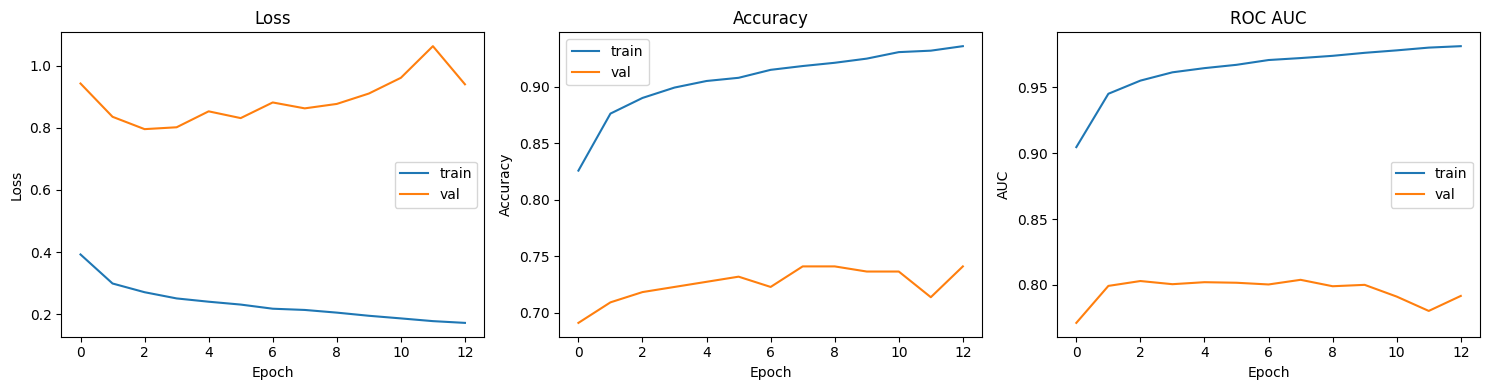

Accuracy of model-10: 0.7409 | ROC_AUC: 0.8039

CNN Model- 11. dropout rate: 0.2
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.


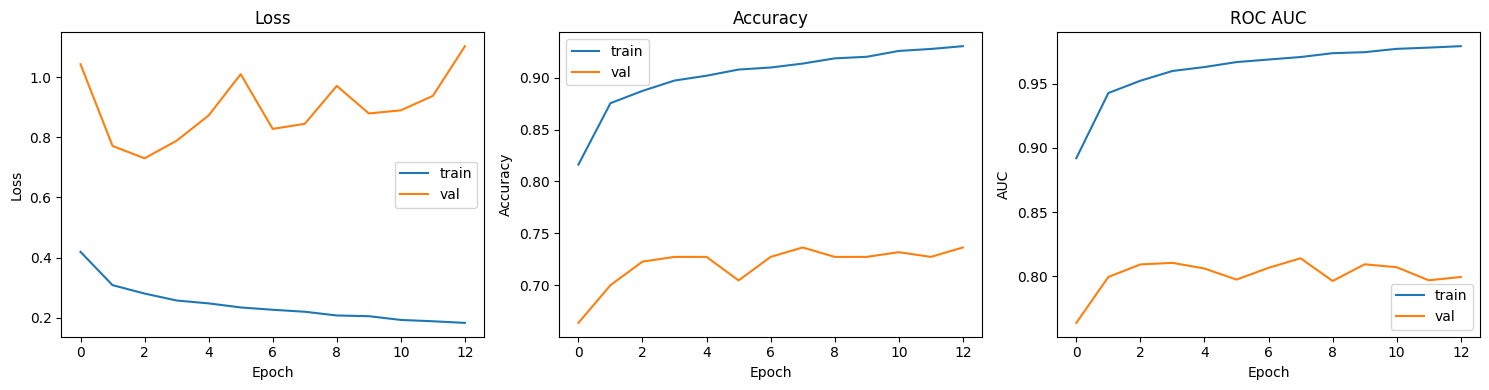

Accuracy of model-11: 0.7364 | ROC_AUC: 0.8141

CNN Model- 12. dropout rate: 0.3
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 9.


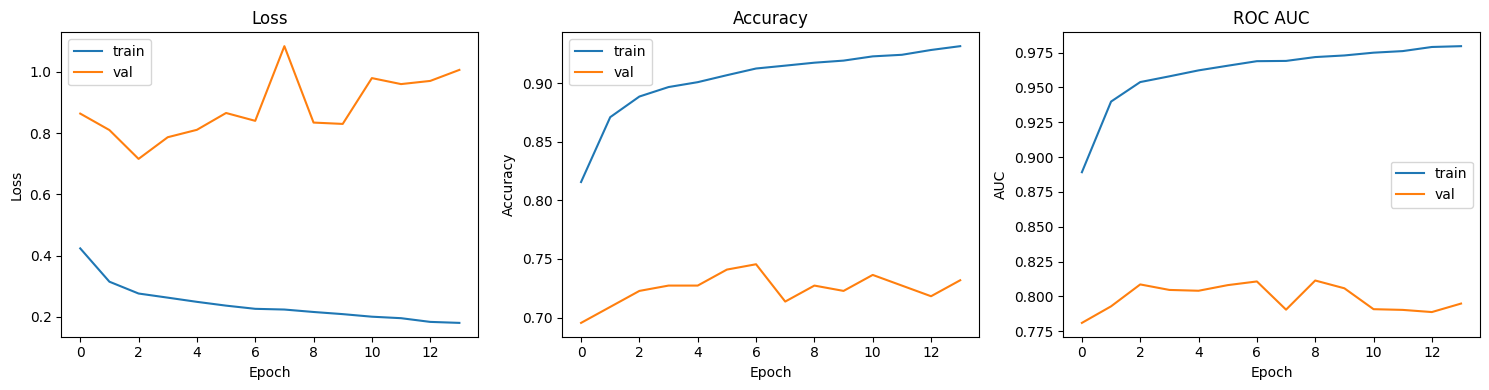

Accuracy of model-12: 0.7455 | ROC_AUC: 0.8114

CNN Model- 13. dropout rate: 0.5
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.


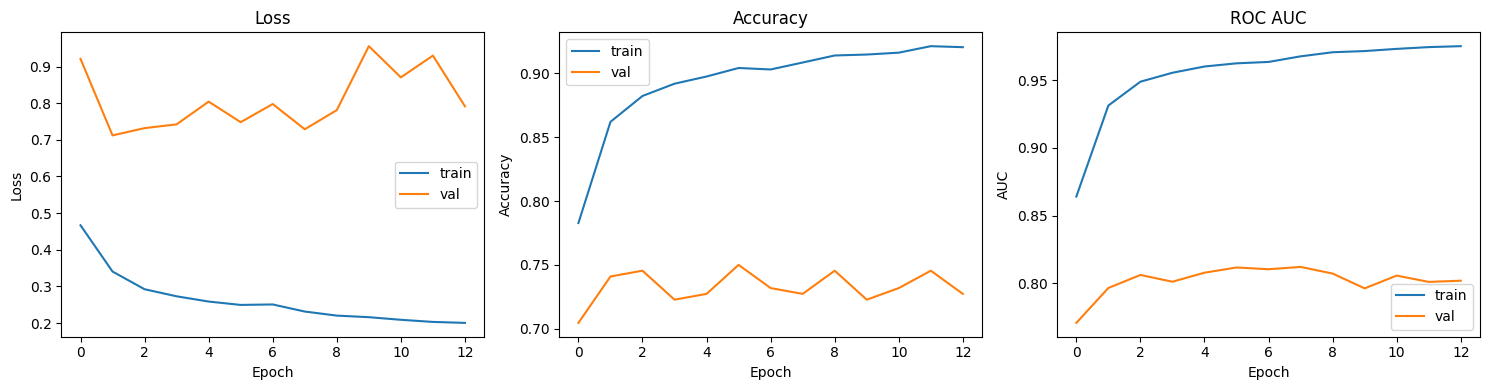

Accuracy of model-13: 0.7500 | ROC_AUC: 0.8120



In [41]:
for dropout_rate in dropout_grid:
    num_model_cnn += 1

    print(f"CNN Model- {num_model_cnn}. dropout rate: {dropout_rate}")

    cfg = {**FIXED, "dropout": dropout_rate}

    model = model_textcnn_factory(
        conv_filters=hiddensizes_cnn,   # ← 用之前选好的 filters
        conv_activation=actfn_cnn,      # ← 用之前选好的激活层实例
        **cfg
    )

    history = model.fit(
        X_train, y_train,
        epochs=40, batch_size=32,
        callbacks=[es],
        validation_data=(X_val, y_val),
        verbose=0
    )

    val_acc = float(np.max(history.history.get("val_accuracy", [0.0])))
    val_auc = float(np.max(history.history.get("val_roc_auc", [0.0])))
    results_cnn2.append([round(val_acc, 4), round(val_auc, 4),
                         num_model_cnn, dropout_rate])

    try:
        plot_history(history)
    except TypeError:
        model_name = f'CNN Model {num_model_cnn} (dropout={dropout_rate})'
        plot_history(history, model_name)

    print(f"Accuracy of model-{num_model_cnn}: {val_acc:.4f} | ROC_AUC: {val_auc:.4f}\n")

In [42]:
results_cnn2.sort(key=lambda x: (x[1], x[0]), reverse=True)
print("Sorted (val_acc, val_auc, id, dropout):")
for row in results_cnn2:
    print(row)

Sorted (val_acc, val_auc, id, dropout):
[0.7364, 0.8141, 11, 0.2]
[0.75, 0.812, 13, 0.5]
[0.7455, 0.8114, 12, 0.3]
[0.7409, 0.8039, 10, 0.05]


In [45]:
best_row = results_cnn2[0]   # [val_acc, val_auc, id, actfn, conv_filters]
best_dropout = best_row[3]

dropout_rate = best_dropout

print(f"✅ Best CNN Config | val_acc={best_acc_cnn}, val_auc={best_auc_cnn}, "
      f"dropout_rate={dropout_rate}")

✅ Best CNN Config | val_acc=0.7455, val_auc=0.818, dropout_rate=0.2


In [47]:
FIXED.pop('optimizer_cls', None)
FIXED.pop('learning_rate', None)
FIXED

{'dense_units': 64,
 'dense_activation': 'relu',
 'input_shape': (100, 768),
 'kernel_sizes': (3, 5, 7)}

In [48]:
optimizer_grid = [keras.optimizers.Nadam, keras.optimizers.Adam, keras.optimizers.RMSprop]

lr_grid_map = {
    "Nadam":  [2e-3, 1e-3, 5e-4, 2e-4, 1e-4],
    "Adam":   [2e-3, 1e-3, 5e-4, 2e-4, 1e-4],
    "RMSprop":[1e-3, 5e-4, 2e-4, 1e-4],
}

In [49]:
results_cnn3 = []

Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.


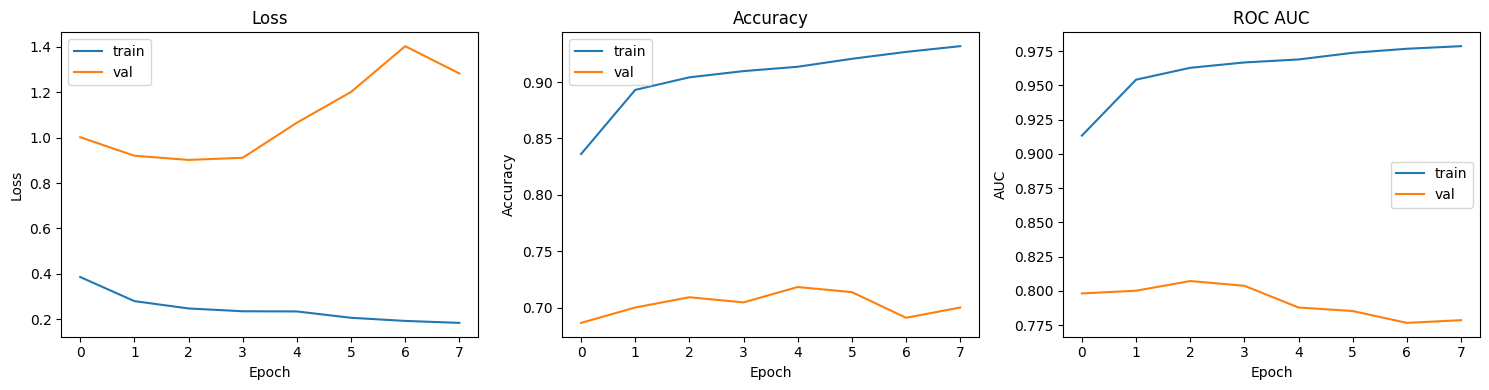

Accuracy of model-13: 0.7182 | ROC_AUC: 0.8072

Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


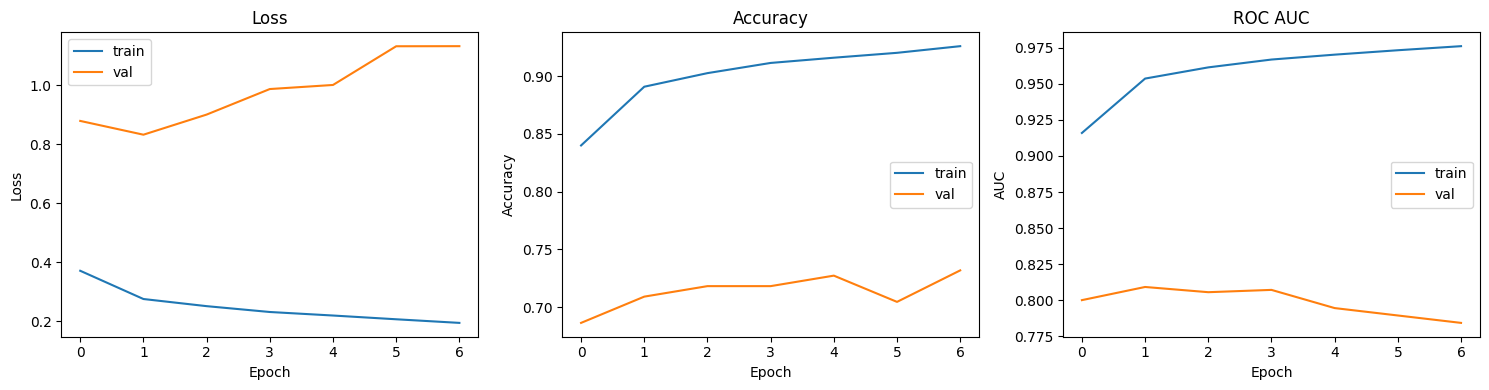

Accuracy of model-13: 0.7318 | ROC_AUC: 0.8093

Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.


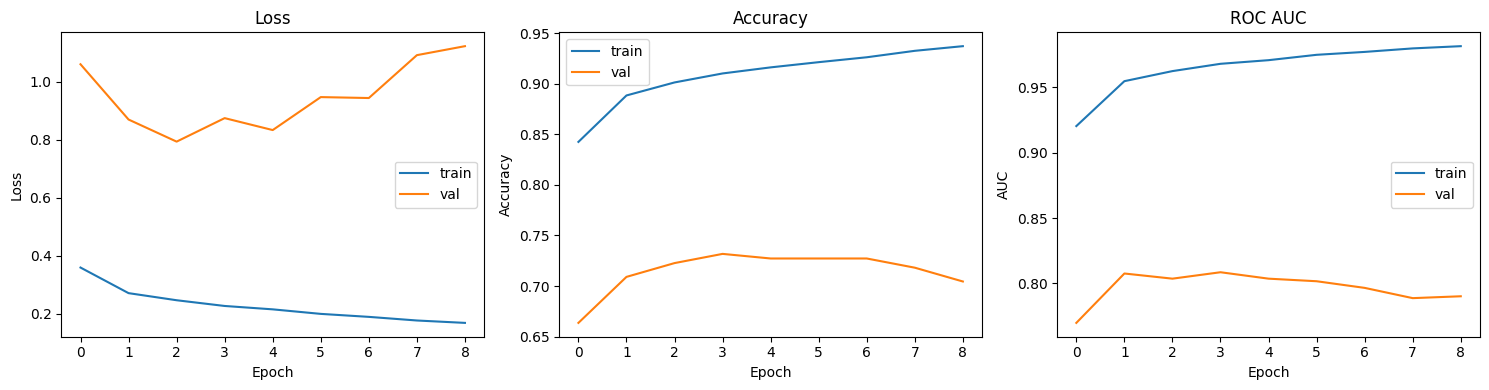

Accuracy of model-13: 0.7318 | ROC_AUC: 0.8085

Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.


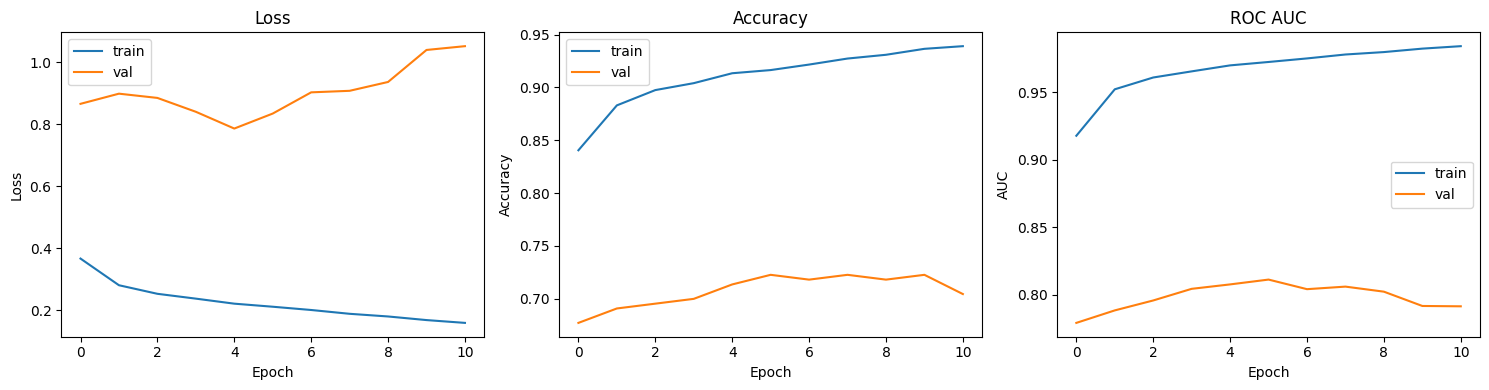

Accuracy of model-13: 0.7227 | ROC_AUC: 0.8113

Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.


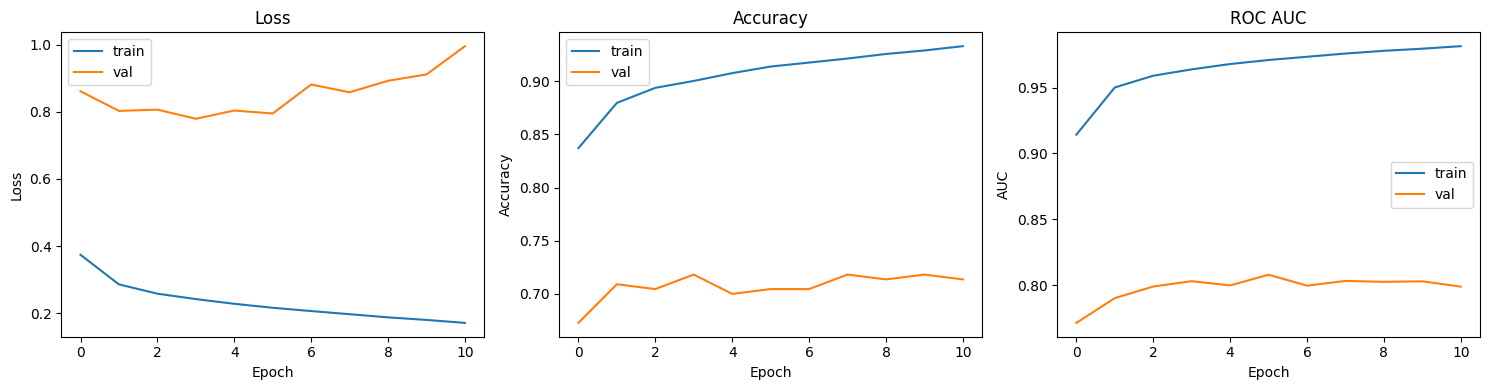

Accuracy of model-13: 0.7182 | ROC_AUC: 0.8078

Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.


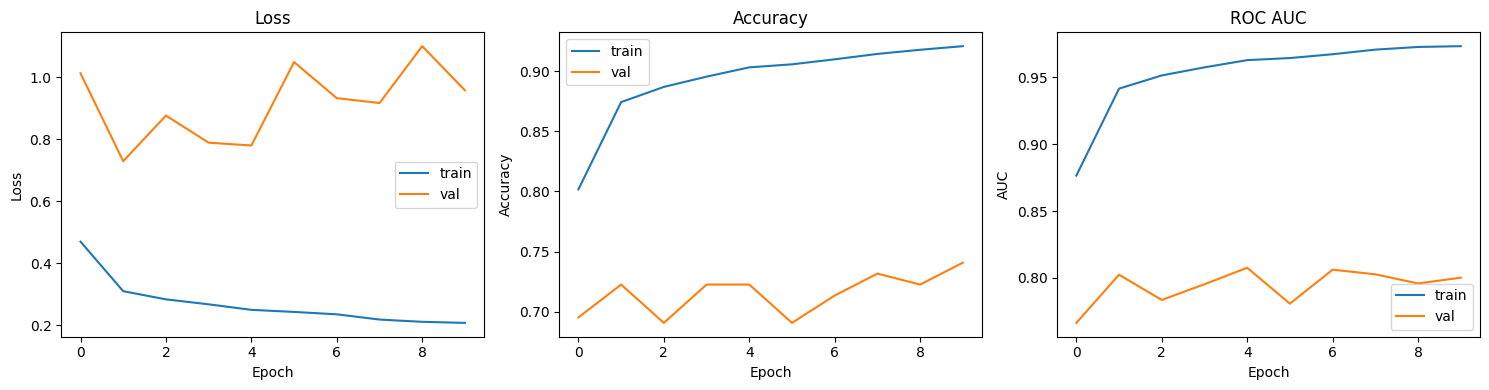

Accuracy of model-13: 0.7409 | ROC_AUC: 0.8075

Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.


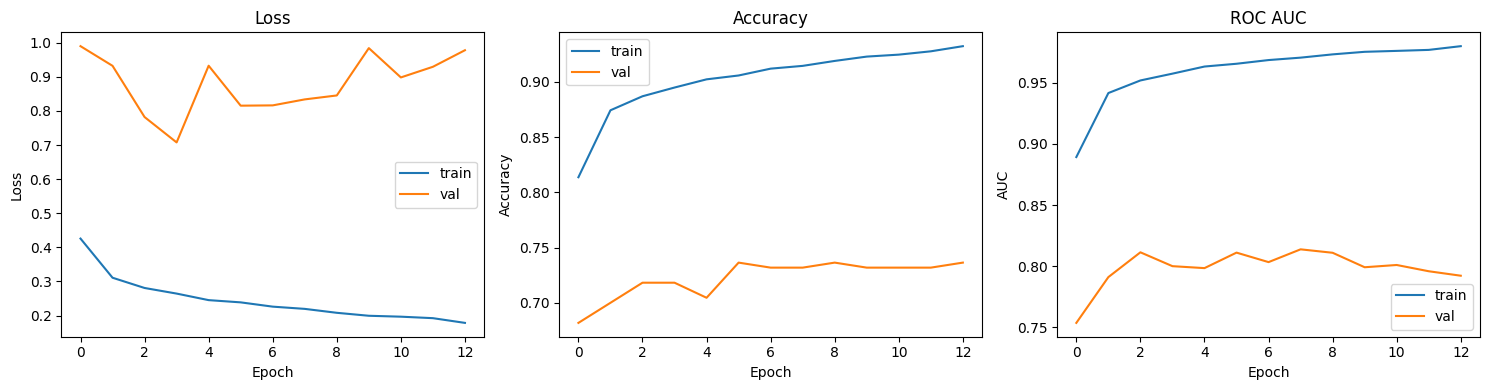

Accuracy of model-13: 0.7364 | ROC_AUC: 0.8138

Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.


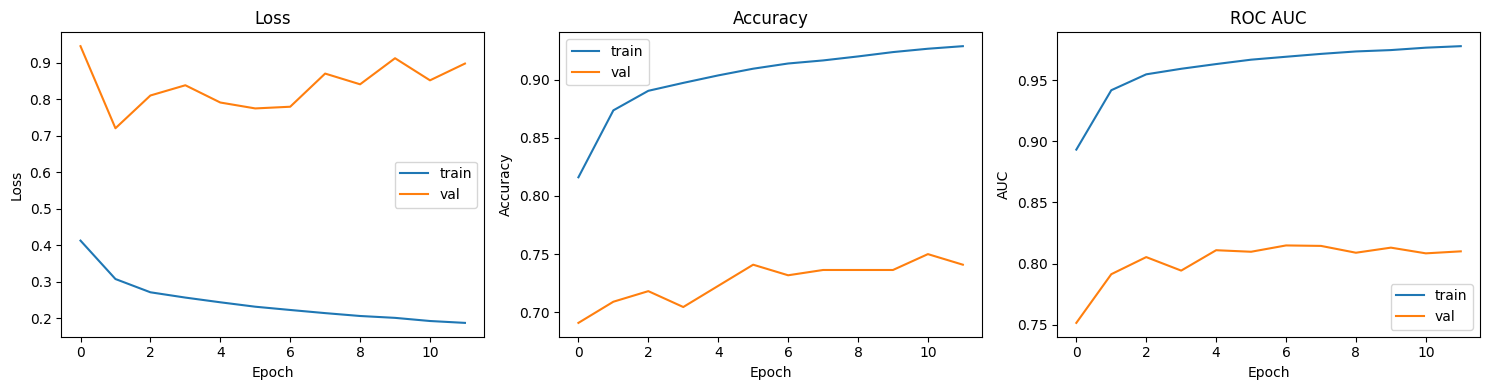

Accuracy of model-13: 0.7500 | ROC_AUC: 0.8148

Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.


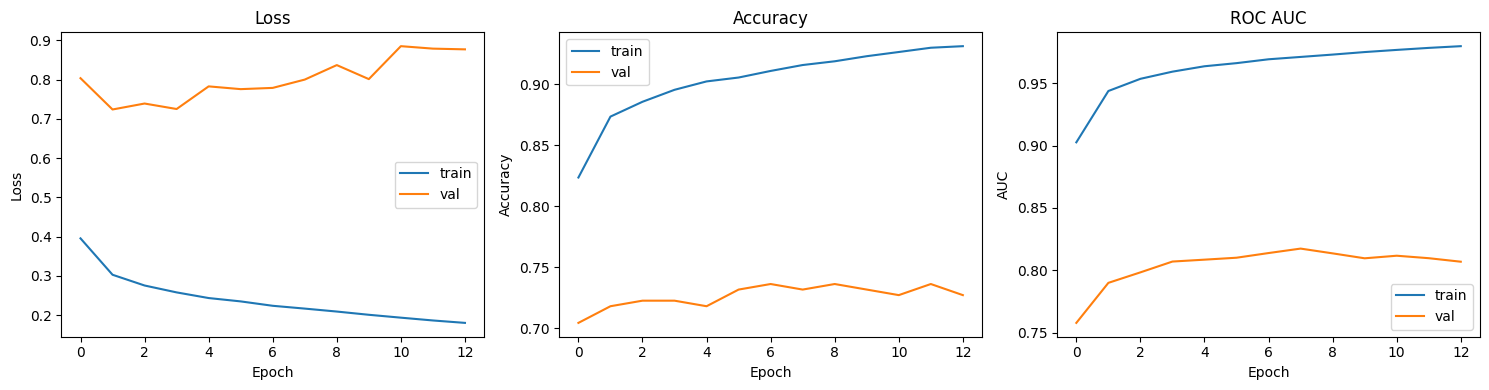

Accuracy of model-13: 0.7364 | ROC_AUC: 0.8175

Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.


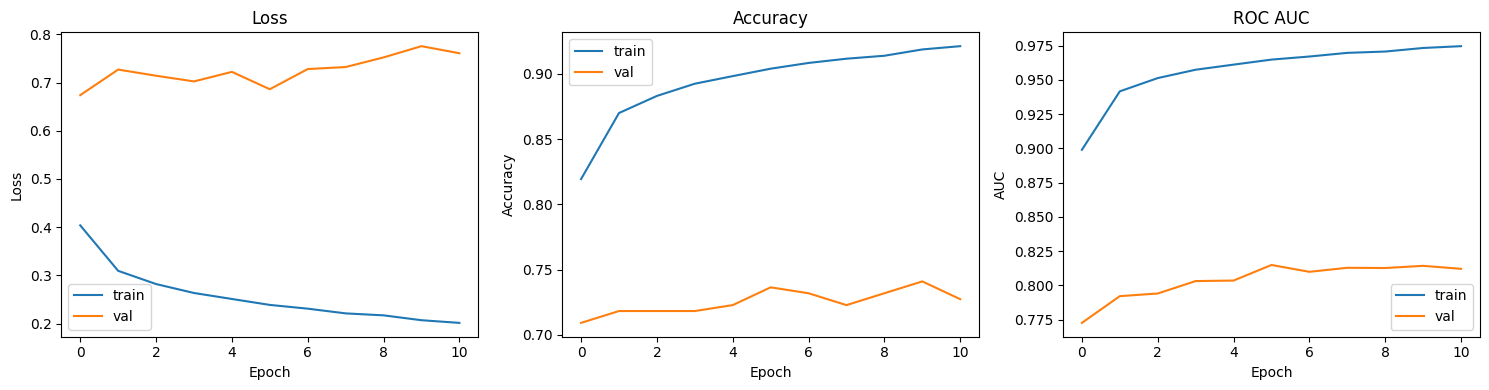

Accuracy of model-13: 0.7409 | ROC_AUC: 0.8149

Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.


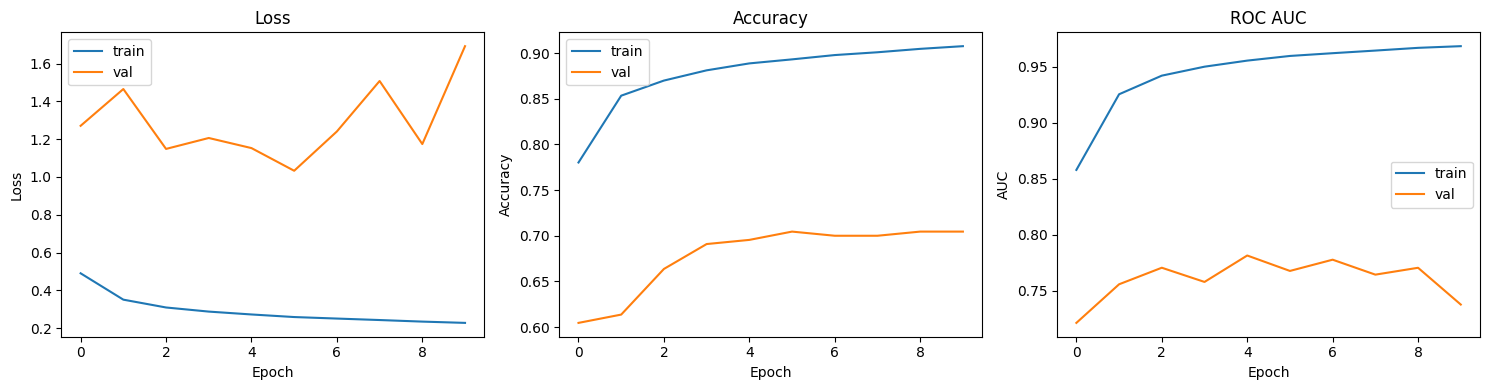

Accuracy of model-13: 0.7045 | ROC_AUC: 0.7813

Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 11.


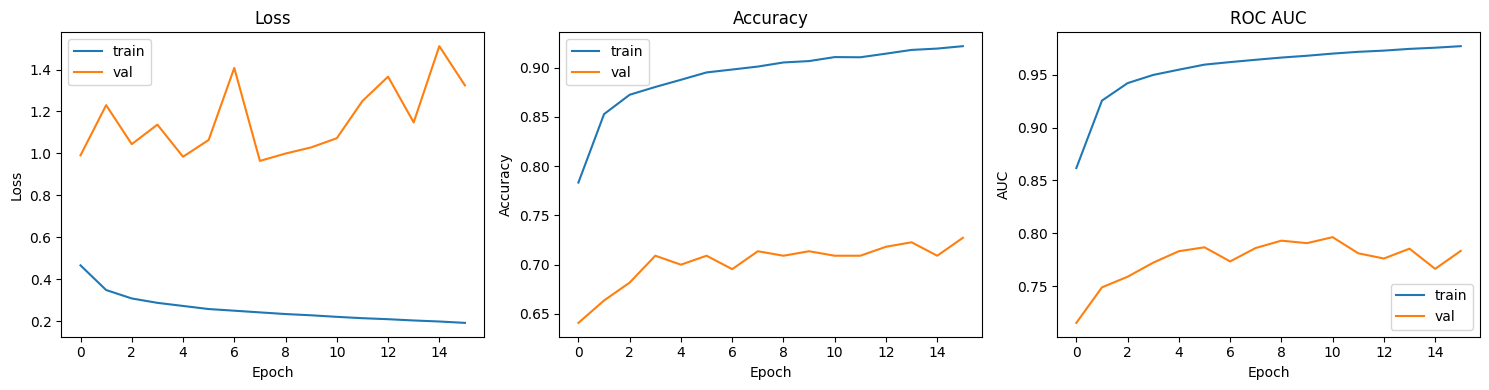

Accuracy of model-13: 0.7273 | ROC_AUC: 0.7963

Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 10.


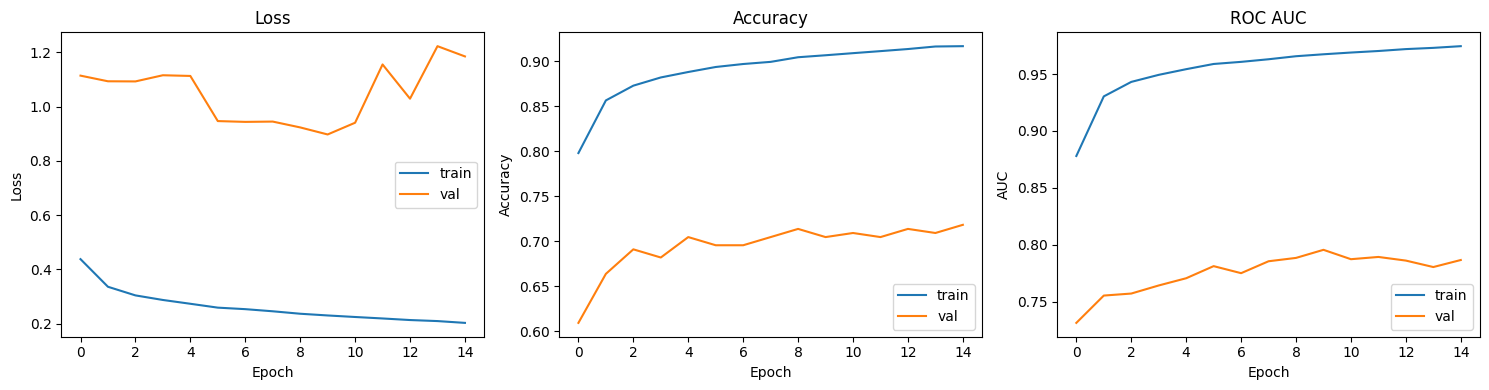

Accuracy of model-13: 0.7182 | ROC_AUC: 0.7957

Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 19.


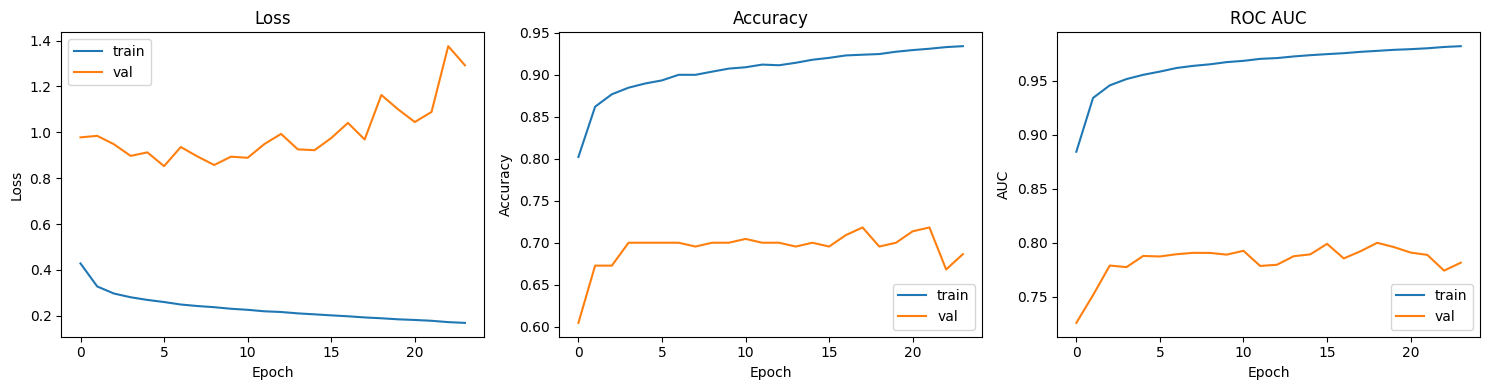

Accuracy of model-13: 0.7182 | ROC_AUC: 0.7999



In [51]:
for opt_cls in optimizer_grid:
    name = opt_cls.__name__
    for lr in lr_grid_map[name]:
        model = model_textcnn_factory(
            conv_filters=hiddensizes_cnn,
            conv_activation=actfn_cnn,
            dropout=dropout_rate,
            **{**FIXED, "optimizer_cls": opt_cls, "learning_rate": lr}
        )
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=40, batch_size=32,
            callbacks=[es],
            verbose=0
        )

        val_acc = float(np.max(history.history.get("val_accuracy", [0.0])))
        val_auc = float(np.max(history.history.get("val_roc_auc", [0.0])))
        results_cnn3.append([round(val_acc, 4), round(val_auc, 4), num_model_cnn, opt_cls, lr])

        try:
          plot_history(history)
        except TypeError:
          model_name = f'CNN Model {num_model_cnn} (Optimizer={opt_cls} (learning_rate={lr})'
          plot_history(history, model_name)
        print(f"Accuracy of model-{num_model_cnn}: {val_acc:.4f} | ROC_AUC: {val_auc:.4f}\n")

In [52]:
results_cnn3.sort(key=lambda x: (x[1], x[0]), reverse=True)
print("Sorted (val_acc, val_auc, id, opt_cls, lr):")
for row in results_cnn3:
    print(row)

Sorted (val_acc, val_auc, id, opt_cls, lr):
[0.7364, 0.8175, 13, <class 'keras.src.optimizers.adam.Adam'>, 0.0002]
[0.7409, 0.8149, 13, <class 'keras.src.optimizers.adam.Adam'>, 0.0001]
[0.75, 0.8148, 13, <class 'keras.src.optimizers.adam.Adam'>, 0.0005]
[0.7364, 0.8138, 13, <class 'keras.src.optimizers.adam.Adam'>, 0.001]
[0.7227, 0.8113, 13, <class 'keras.src.optimizers.nadam.Nadam'>, 0.0002]
[0.7318, 0.8093, 13, <class 'keras.src.optimizers.nadam.Nadam'>, 0.001]
[0.7318, 0.8085, 13, <class 'keras.src.optimizers.nadam.Nadam'>, 0.0005]
[0.7182, 0.8078, 13, <class 'keras.src.optimizers.nadam.Nadam'>, 0.0001]
[0.7409, 0.8075, 13, <class 'keras.src.optimizers.adam.Adam'>, 0.002]
[0.7182, 0.8072, 13, <class 'keras.src.optimizers.nadam.Nadam'>, 0.002]
[0.7182, 0.7999, 13, <class 'keras.src.optimizers.rmsprop.RMSprop'>, 0.0001]
[0.7273, 0.7963, 13, <class 'keras.src.optimizers.rmsprop.RMSprop'>, 0.0005]
[0.7182, 0.7957, 13, <class 'keras.src.optimizers.rmsprop.RMSprop'>, 0.0002]
[0.7045, 0.

In [54]:
best_row = results_cnn3[0]   # [val_acc, val_auc, id, actfn, conv_filters]
best_optimizer = best_row[3]
best_learningrate = best_row[4]

optimizer_cls = best_optimizer
learning_rate = best_learningrate

print(f"✅ Best CNN Config | val_acc={best_acc_cnn}, val_auc={best_auc_cnn}, "
      f"best_optimizer={optimizer_cls}, best_learning rate={learning_rate}")

✅ Best CNN Config | val_acc=0.7455, val_auc=0.818, best_optimizer=<class 'keras.src.optimizers.adam.Adam'>, best_learning rate=0.0002


Try add ReduceLROnPlateau

In [56]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_roc_auc", factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

In [58]:
FIXED.pop("dense_units", None)
FIXED.pop("dense_activation", None)
FIXED

{'input_shape': (100, 768), 'kernel_sizes': (3, 5, 7)}

In [59]:
dense_units_grid = [64, 128, 256]
dense_act_grid   = ["relu", "elu", keras.layers.LeakyReLU]

In [66]:
results_cnn4 = []

In [71]:
best_conv_filters = hiddensizes_cnn          # e.g. 128
best_conv_act     = actfn_cnn                # e.g. "relu" 或 keras.layers.LeakyReLU
best_dropout      = dropout_rate                    # 如你之前找到的
best_opt_cls      = keras.optimizers.Adam    # 如你之前找到的
best_lr         = 2e-4                     # 如你之前找到的

In [72]:
def get_act_name(a):
    if isinstance(a, str): return a
    if isinstance(a, type): return a.__name__      # 层类，如 keras.layers.LeakyReLU
    if callable(a): return getattr(a, "__name__", "callable")
    return a.__class__.__name__                    # 层实例

CNN Model- 14. dense_units: 64, dense_activation: relu
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.


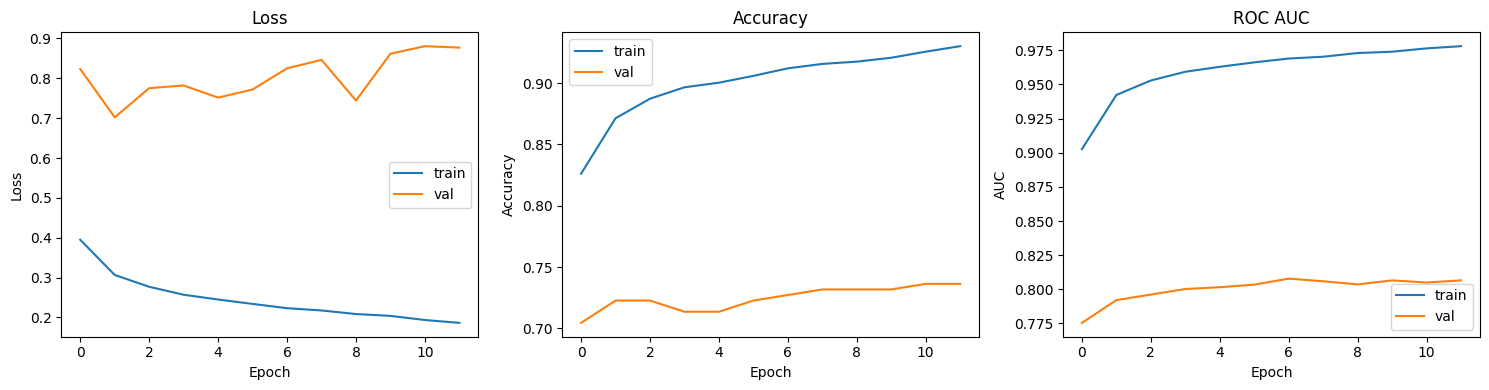

Accuracy of model-14: 0.7364 | ROC_AUC: 0.8078

CNN Model- 15. dense_units: 64, dense_activation: elu
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 10.


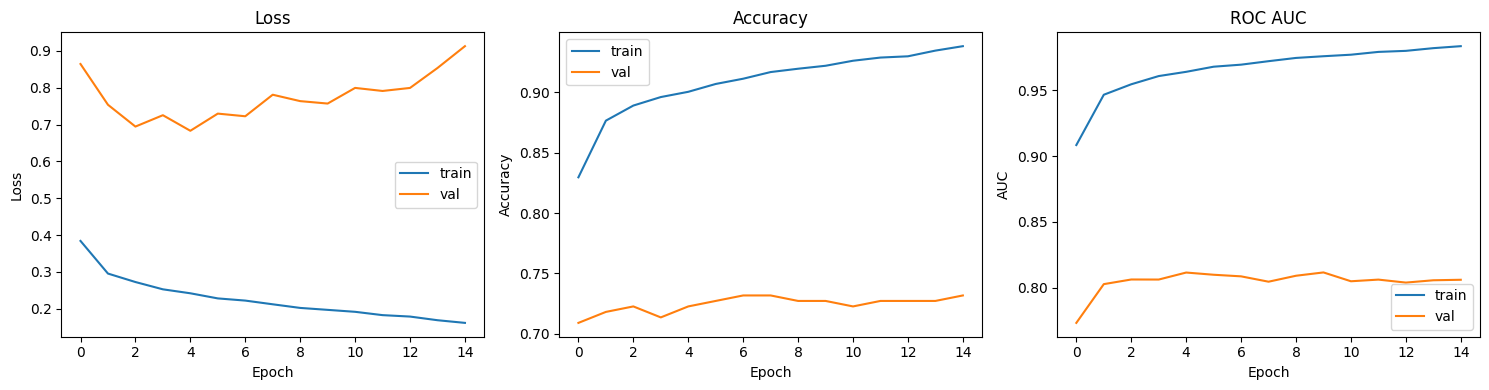

Accuracy of model-15: 0.7318 | ROC_AUC: 0.8115

CNN Model- 16. dense_units: 64, dense_activation: LeakyReLU
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.


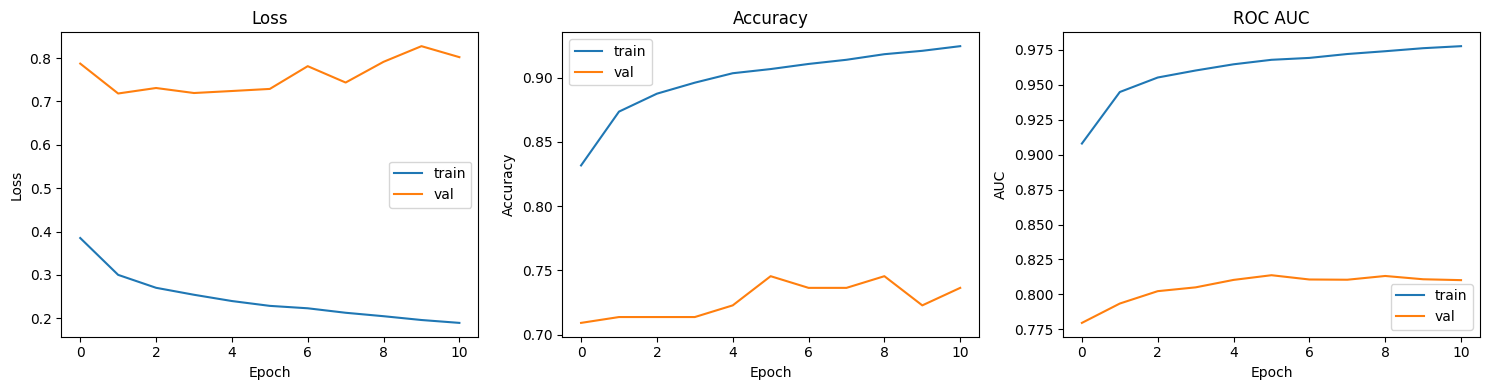

Accuracy of model-16: 0.7455 | ROC_AUC: 0.8137

CNN Model- 17. dense_units: 128, dense_activation: relu
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 9.


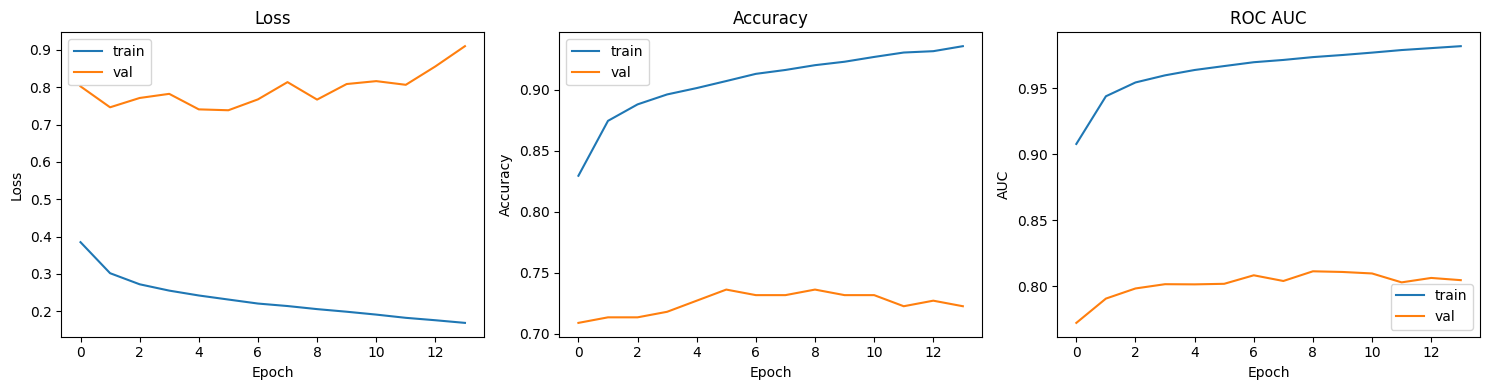

Accuracy of model-17: 0.7364 | ROC_AUC: 0.8112

CNN Model- 18. dense_units: 128, dense_activation: elu
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.


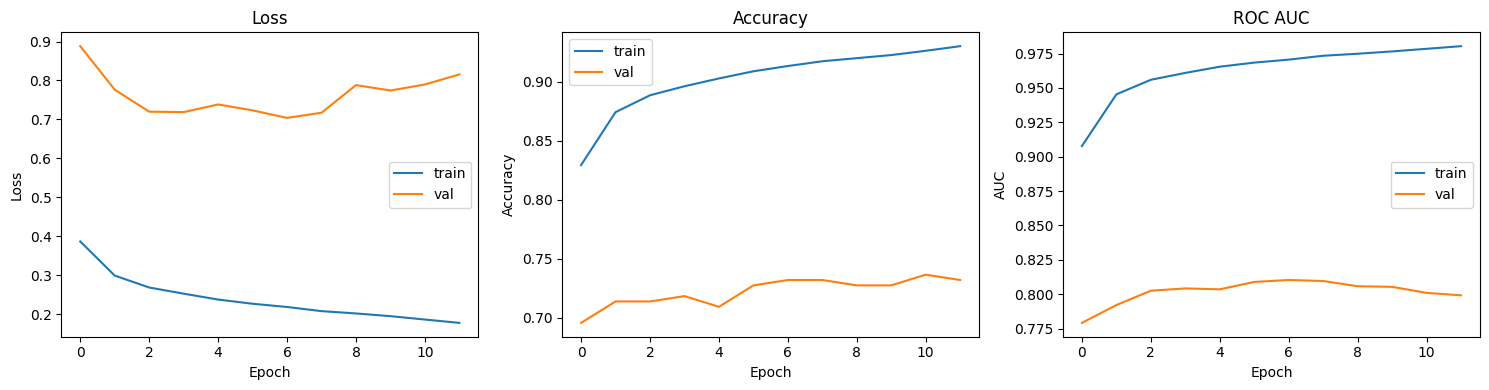

Accuracy of model-18: 0.7364 | ROC_AUC: 0.8103

CNN Model- 19. dense_units: 128, dense_activation: LeakyReLU
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.


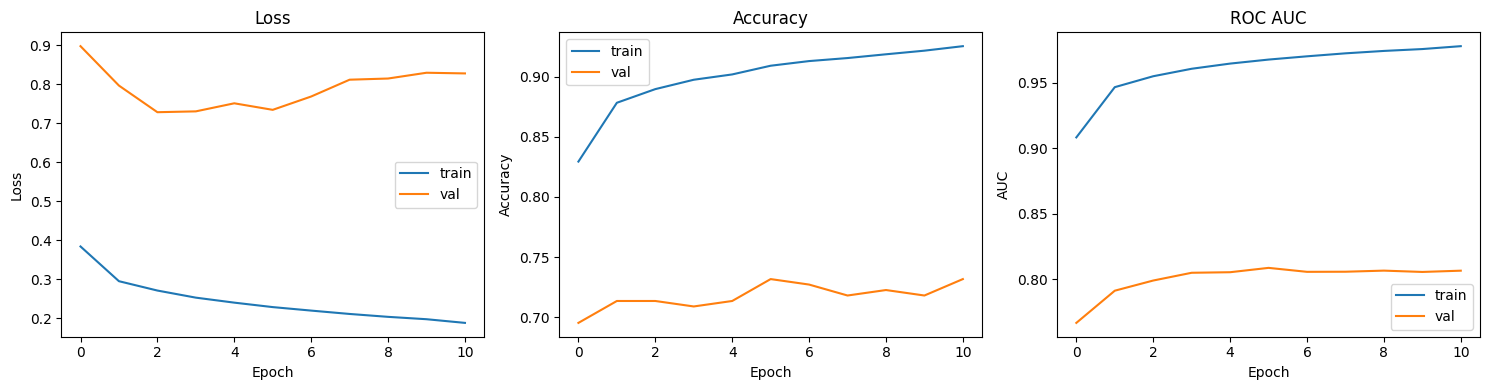

Accuracy of model-19: 0.7318 | ROC_AUC: 0.8088

CNN Model- 20. dense_units: 256, dense_activation: relu
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 9.


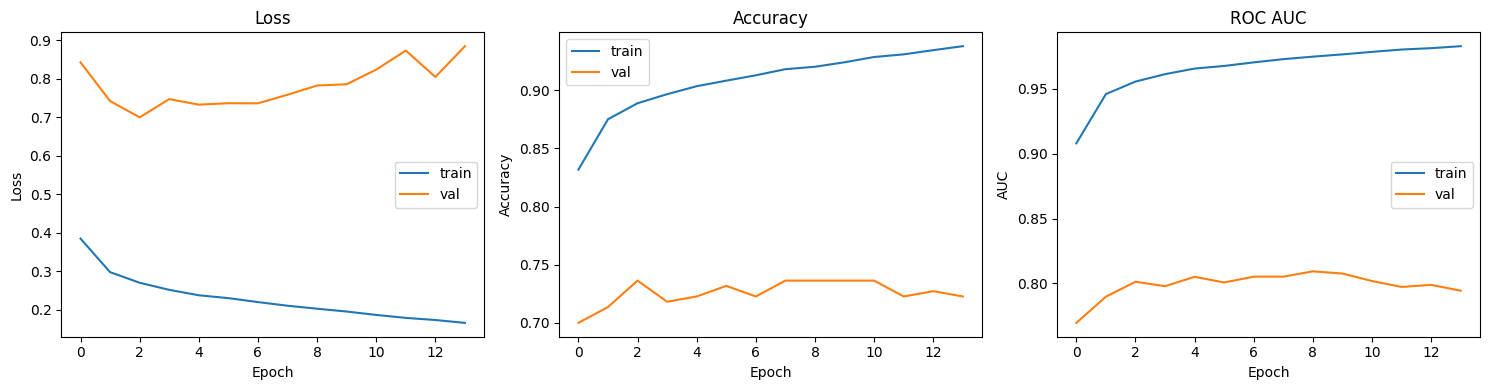

Accuracy of model-20: 0.7364 | ROC_AUC: 0.8093

CNN Model- 21. dense_units: 256, dense_activation: elu
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.


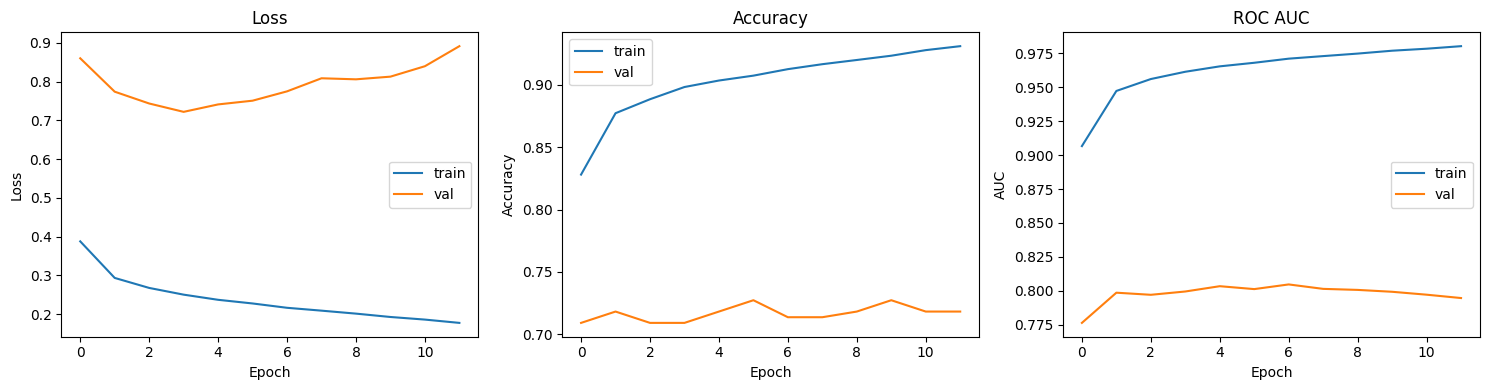

Accuracy of model-21: 0.7273 | ROC_AUC: 0.8046

CNN Model- 22. dense_units: 256, dense_activation: LeakyReLU
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.


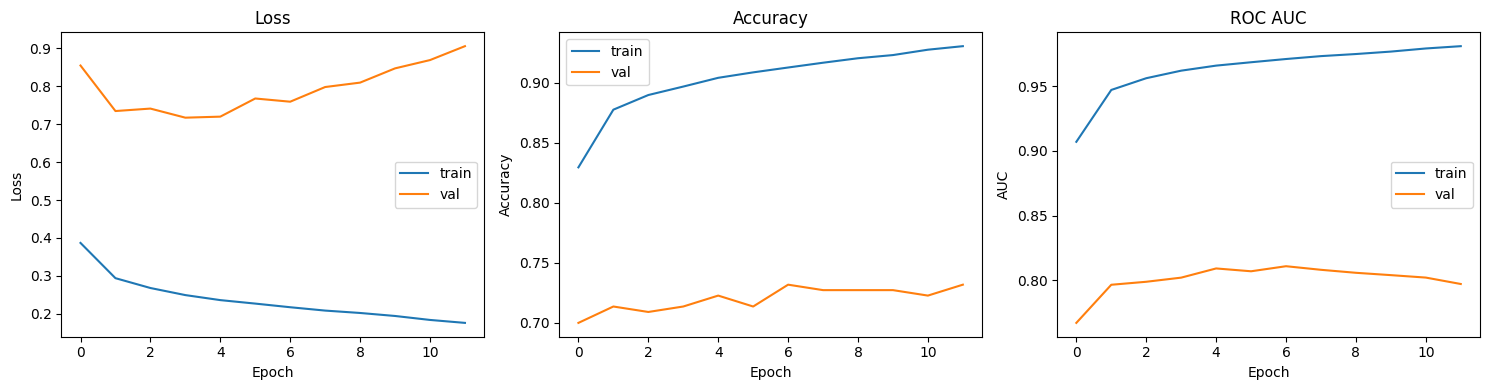

Accuracy of model-22: 0.7318 | ROC_AUC: 0.8109



In [73]:
for du in dense_units_grid:                  # 例如 [None, 64, 128, 256, 384]
    for da in dense_act_grid:                # 例如 ["relu", keras.layers.LeakyReLU, "elu"]
        num_model_cnn += 1
        tf.keras.backend.clear_session()

        act_name = get_act_name(da)
        print(f"CNN Model- {num_model_cnn}. dense_units: {du}, dense_activation: {act_name}")

        # 统一构造 cfg，用一次 **cfg 传入，避免重复参数冲突
        cfg = {
            **FIXED,
            "conv_filters":     best_conv_filters,
            "conv_activation":  best_conv_act,
            "dropout":          best_dropout,     # 注意是 dropout，不是 dropout_rate
            "optimizer_cls":    best_opt_cls,
            "learning_rate":    best_lr,
            "dense_units":      du,
            "dense_activation": da,
        }

        model = model_textcnn_factory(**cfg)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=40, batch_size=32,
            callbacks=[es],                     # 建议 monitor="val_roc_auc"
            verbose=0
        )

        val_acc = float(np.max(history.history.get("val_accuracy", [0.0])))
        val_auc = float(np.max(history.history.get("val_roc_auc", [0.0])))
        results_cnn4.append([round(val_acc, 4), round(val_auc, 4),
                             num_model_cnn, du, act_name])

        try:
            plot_history(history)
        except TypeError:
            plot_history(history, f"Dense={du}, Act={act_name}")

        print(f"Accuracy of model-{num_model_cnn}: {val_acc:.4f} | ROC_AUC: {val_auc:.4f}\n")

In [74]:
results_cnn4.sort(key=lambda x: (x[1], x[0]), reverse=True)
print("Sorted (val_acc, val_auc, id, dense_units, dense_act):")
for row in results_cnn4:
    print(row)

Sorted (val_acc, val_auc, id, dense_units, dense_act):
[0.7455, 0.8137, 16, 64, 'LeakyReLU']
[0.7318, 0.8115, 15, 64, 'elu']
[0.7364, 0.8112, 17, 128, 'relu']
[0.7318, 0.8109, 22, 256, 'LeakyReLU']
[0.7364, 0.8103, 18, 128, 'elu']
[0.7364, 0.8093, 20, 256, 'relu']
[0.7318, 0.8088, 19, 128, 'LeakyReLU']
[0.7364, 0.8078, 14, 64, 'relu']
[0.7273, 0.8046, 21, 256, 'elu']


In [108]:
best_acc4, best_auc4, best_id4, best_du4, best_da4 = results_cnn4[0]

if best_da4.lower() == "relu":
    best_da4 = "relu"
elif best_da4.lower() == "elu":
    best_da4 = "elu"
else:
    best_da4 = keras.layers.LeakyReLU  # 注意用 negative_slope 替代 alpha

print(f"\n✅ Best head: dense_units={best_du4}, dense_activation={best_da4} "
      f"| val_acc={best_acc4:.4f} | val_auc={best_auc4:.4f}")


✅ Best head: dense_units=64, dense_activation=<class 'keras.src.layers.activations.leaky_relu.LeakyReLU'> | val_acc=0.7455 | val_auc=0.8137


add reducelr see changes

In [109]:
best_conv_filters = hiddensizes_cnn
best_conv_act = actfn_cnn
best_dropout = dropout_rate
best_opt_cls = optimizer_cls
best_lr = learning_rate
best_dense_units = best_du4
best_dense_act = best_da4

In [147]:
results_cnn5 = []

In [148]:
cfg = {
    **FIXED,                              # 其他固定超参
    "conv_filters":     best_conv_filters,
    "conv_activation":  best_conv_act,
    "dropout":          best_dropout,     # 覆盖 FIXED 里的 dropout
    "optimizer_cls":    best_opt_cls,     # 比如 keras.optimizers.Adam
    "learning_rate":    best_lr,          # 比如 2e-4
    "dense_units":      best_dense_units, # 允许 None
    "dense_activation": best_dense_act,   # "relu" / keras.layers.LeakyReLU / "elu" 等
}

In [149]:
from functools import partial

cfg_clip = {**cfg}
cfg_clip["optimizer_cls"] = partial(cfg["optimizer_cls"], clipnorm=1.0)

In [150]:
keras.backend.clear_session()
es_auc = keras.callbacks.EarlyStopping(monitor="val_roc_auc", mode="max",
                                       patience=10, restore_best_weights=True, verbose=1)

In [151]:
model_clip = model_textcnn_factory(**cfg_clip)
history_clip = model_clip.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60, batch_size=32,
    callbacks=[es_auc],
    verbose=1
)

Epoch 1/60
511/511 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7896 - loss: 0.4470 - roc_auc: 0.8696 - val_accuracy: 0.7136 - val_loss: 0.7022 - val_roc_auc: 0.7851
Epoch 2/60
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8701 - loss: 0.3147 - roc_auc: 0.9405 - val_accuracy: 0.7045 - val_loss: 0.7760 - val_roc_auc: 0.7931
Epoch 3/60
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8869 - loss: 0.2756 - roc_auc: 0.9541 - val_accuracy: 0.7227 - val_loss: 0.7464 - val_roc_auc: 0.7993
Epoch 4/60
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8895 - loss: 0.2618 - roc_auc: 0.9587 - val_accuracy: 0.7318 - val_loss: 0.7395 - val_roc_auc: 0.8048
Epoch 5/60
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8962 - loss: 0.2476 - roc_auc: 0.9629 - val_accuracy: 0.7045 - val_loss: 0.7898 - val_roc_auc: 0.8136
Epoch 6/60
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9039 - loss: 0.2375 - roc_auc: 0.9658 - val_accuracy: 0.7182 - val_loss: 0.7934 - val_ro

[With clipnorm] val_acc=0.7500 | val_roc_auc=0.8254


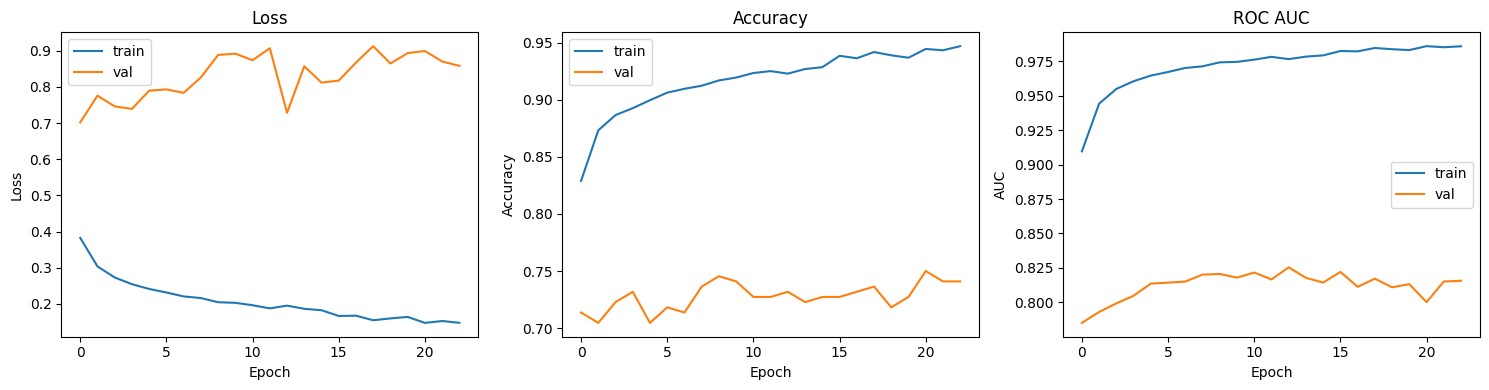

In [152]:
best_val_acc = float(np.max(history_clip.history.get("val_accuracy", [0.0])))
best_val_auc = float(np.max(history_clip.history.get("val_roc_auc", [0.0])))
print(f"[With clipnorm] val_acc={best_val_acc:.4f} | val_roc_auc={best_val_auc:.4f}")

plot_history(history_clip)

Update Temporal Best Model

In [155]:
keras.backend.clear_session()
final_model = model_textcnn_factory(**cfg_clip)
final_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 100, 256)  │    590,080 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 100, 256)  │    983,296 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 100, 256)  │  1,376,512 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 100, 256)  │          0 │ conv1d[0][0]      │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 100, 256)  │          0 │ conv1d_1[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 100, 256)  │          0 │ conv1d_2[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ leaky_re_lu[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ leaky_re_lu_1[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ leaky_re_lu_2[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 768)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     49,216 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64)        │          0 │ dense[0][0]       │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,999,169 (11.44 MB)

 Trainable params: 2,999,169 (11.44 MB)

 Non-trainable params: 0 (0.00 B)

In [156]:
es_auc = keras.callbacks.EarlyStopping(monitor="val_roc_auc", patience=10, restore_best_weights=True, verbose=1)

In [157]:
history_final = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60, batch_size=32,
    callbacks=[es_auc],
    verbose=1
)

Epoch 1/60
511/511 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7858 - loss: 0.4610 - roc_auc: 0.8623 - val_accuracy: 0.7136 - val_loss: 0.7598 - val_roc_auc: 0.7590
Epoch 2/60
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8673 - loss: 0.3121 - roc_auc: 0.9412 - val_accuracy: 0.7091 - val_loss: 0.7746 - val_roc_auc: 0.7891
Epoch 3/60
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8859 - loss: 0.2770 - roc_auc: 0.9539 - val_accuracy: 0.7318 - val_loss: 0.7115 - val_roc_auc: 0.8030
Epoch 4/60
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8923 - loss: 0.2590 - roc_auc: 0.9591 - val_accuracy: 0.7091 - val_loss: 0.7662 - val_roc_auc: 0.8047
Epoch 5/60
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8974 - loss: 0.2451 - roc_auc: 0.9634 - val_accuracy: 0.7136 - val_loss: 0.7739 - val_roc_auc: 0.8131
Epoch 6/60
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9031 - loss: 0.2367 - roc_auc: 0.9660 - val_accuracy: 0.7273 - val_loss: 0.7777 - val_ro

In [159]:
evaluate_model(final_model, X_val, y_val, ids=val_ids, agg="mean")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Sample-level AUROC: 0.8194
Classification Report (sample-level):
              precision    recall  f1-score   support

           0      0.711     0.911     0.799       124
           1      0.820     0.521     0.637        96

    accuracy                          0.741       220
   macro avg      0.765     0.716     0.718       220
weighted avg      0.758     0.741     0.728       220

Doc-level AUROC (mean): 1.0


In [160]:
y_test_prob_final = final_model.predict(X_test).ravel()
df_probs_final = pd.DataFrame({'id': test_ids, 'prob': y_test_prob_final})
final_probs = df_probs_final.groupby('id')['prob'].mean().reset_index()
print(final_probs.head())

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
   id      prob
0  15  0.037536
1  16  0.142301
2  17  0.024732
3  18  0.508339
4  19  0.106838


In [161]:
out_dir = "/content/drive/MyDrive/my_exports"  # 你想保存的文件夹
os.makedirs(out_dir, exist_ok=True)

save_path = os.path.join(out_dir, "final_probs.csv")
final_probs.to_csv(save_path, index=False, encoding="utf-8")
print("Saved to:", save_path)

Saved to: /content/drive/MyDrive/my_exports/final_probs.csv
